🔧 Cell 1 — Imports, config, helpers

In [2]:
# --- Imports
import os, json, warnings, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf
import pandas_market_calendars as mcal
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, losses, metrics, backend as K

warnings.filterwarnings("ignore")
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

# --- Config
LOOKBACK        = 60               # must match your AAPL-Open model's lookback
TRIM_YEARS      = 10
CALENDAR        = "XNYS"
MAX_FUTURE_DAYS = 252

OPEN_BASE_DIR   = "models/base_aapl_open"  # <-- your saved AAPL-Open bundle
CLOSE_BASE_DIR  = "models/base_aapl"       # optional: for prev-close path (if available)

# --- Small helpers
def r2_metric(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1.0 - ss_res / (ss_tot + K.epsilon())

def _last_completed_utc_day():
    return (pd.Timestamp.utcnow().normalize() - pd.Timedelta(days=1))

def _utc_midnight_naive(ts):
    ts = pd.Timestamp(ts)
    if ts.tzinfo is None or ts.tz is None:
        ts = ts.tz_localize("UTC")
    else:
        ts = ts.tz_convert("UTC")
    return ts.normalize().tz_localize(None)

def _resolve_dates(start=None, end=None):
    s = pd.Timestamp(start) if start else pd.Timestamp("2000-01-01")
    e = pd.Timestamp(end)   if end   else _last_completed_utc_day()
    return _utc_midnight_naive(s), _utc_midnight_naive(e)

def _flatten_columns(cols, ticker_expected=None):
    if isinstance(cols, pd.MultiIndex):
        if cols.nlevels == 2:
            sec = {t for (_, t) in cols}
            if len(sec) == 1 and (ticker_expected is None or list(sec)[0] == ticker_expected):
                flat = [str(f) for (f, _) in cols]
            else:
                flat = ["_".join([str(x) for x in tup if x is not None]) for tup in cols]
        else:
            flat = ["_".join([str(x) for x in tup if x is not None]) for tup in cols]
    else:
        flat = [str(c) for c in cols]
    return [c.strip().title().replace(" ", "_") for c in flat]

def fetch_ohlcv_yf(ticker, start_dt, end_dt, auto_adjust=True):
    start_s, end_s = str(start_dt.date()), str(end_dt.date())
    df = yf.download(
        tickers=ticker, start=start_s, end=end_s,
        auto_adjust=auto_adjust, progress=False, threads=True, group_by="column"
    )
    if df is None or df.empty:
        raise ValueError(f"No data for {ticker} in {start_s}→{end_s}")
    df.index = pd.to_datetime(df.index, utc=False)
    if getattr(df.index, "tz", None) is not None:
        df.index = df.index.tz_localize(None)
    df = df.sort_index().loc[~df.index.duplicated(keep="first")]
    df.columns = _flatten_columns(df.columns, ticker_expected=ticker.upper())
    for c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df = df.dropna(how="all")

    # align to trading calendar
    cal = mcal.get_calendar(CALENDAR)
    sched = cal.schedule(start_date=start_s, end_date=end_s)
    idx = sched.index
    if getattr(idx, "tz", None) is not None:
        idx = idx.tz_localize(None)
    idx = pd.DatetimeIndex(idx)
    df = df.loc[df.index.intersection(idx)]

    need = {"Open","Close"}
    if not need.issubset(set(df.columns)):
        raise ValueError(f"Missing columns {need - set(df.columns)}")
    df = df.dropna(subset=["Open","Close"])
    if df.empty:
        raise ValueError("All rows dropped after cleaning.")
    return df

def create_sequences_std_overnight(data_scaled: pd.DataFrame, prev_close_series: pd.Series, lookback: int):
    """Sequences of standardized overnight returns + Prev_Close for reconstruction."""
    X, y, pc = [], [], []
    vals = data_scaled["OvernightLogRet"].values
    prev_vals = prev_close_series.reindex(data_scaled.index).values
    for i in range(lookback, len(vals)):
        X.append(vals[i-lookback:i].reshape(lookback,1))
        y.append(vals[i])
        pc.append(prev_vals[i])
    return (np.asarray(X, np.float32),
            np.asarray(y, np.float32),
            np.asarray(pc, np.float32))

def future_trading_days(last_date: pd.Timestamp, n: int) -> pd.DatetimeIndex:
    cal = mcal.get_calendar(CALENDAR)
    start_d = (last_date + pd.Timedelta(days=1)).date()
    end_d   = (last_date + pd.DateOffset(days=max(10, n*3))).date()
    sched = cal.schedule(start_date=start_d, end_date=end_d)
    idx = sched.index
    if getattr(idx, "tz", None) is not None:
        idx = idx.tz_localize(None)
    idx = pd.DatetimeIndex(idx)[:n]
    if len(idx) < n: raise ValueError("Not enough future trading days.")
    return idx


🧠 Cell 2 — User inputs (ticker & N)

In [3]:
try:
    ticker = input("Enter ticker for OPEN forecast (e.g., AAPL, MSFT, NVDA): ").strip().upper()
except EOFError:
    ticker = "AAPL"
ticker = ticker or "AAPL"

try:
    rawN = input(f"Enter FUTURE trading days to forecast (1–{MAX_FUTURE_DAYS}) [Enter=14]: ").strip()
except EOFError:
    rawN = ""
if rawN == "":
    N_FUTURE = 14
else:
    try:
        n = int(rawN)
        assert 1 <= n <= MAX_FUTURE_DAYS
        N_FUTURE = n
    except Exception:
        print("⚠️ Invalid N; using default 14.")
        N_FUTURE = 14

print(f"✅ Inputs → ticker={ticker}, N={N_FUTURE}")


✅ Inputs → ticker=MSFT, N=30


📥 Cell 3 — Fetch & build overnight target + split + scaler

In [4]:
# Fetch & trim
START_DT, END_DT = _resolve_dates(None, None)
raw_df = fetch_ohlcv_yf(ticker, START_DT, END_DT, auto_adjust=True)
ohlc   = raw_df[["Open","Close"]].copy()
cutoff = ohlc.index.max() - pd.DateOffset(years=TRIM_YEARS)
ohlc   = ohlc[ohlc.index >= cutoff].copy()

# Overnight log-return: ln(Open_t / Close_{t-1})
prev_close = ohlc["Close"].shift(1)
ovr_logret = np.log(ohlc["Open"] / prev_close)
ovr_df = pd.DataFrame({"Open": ohlc["Open"], "Prev_Close": prev_close, "OvernightLogRet": ovr_logret}).dropna()

# Splits (70/15/15)
n = len(ovr_df)
train_end = int(n*0.70); val_end = int(n*0.85)
train_df = ovr_df.iloc[:train_end].copy()
val_df   = ovr_df.iloc[train_end:val_end].copy()
test_df  = ovr_df.iloc[val_end:].copy()

# Scaler: use base scaler for AAPL; fit fresh scaler for other tickers
import joblib
if ticker == "AAPL":
    base_scaler_path = os.path.join(OPEN_BASE_DIR, "scaler.pkl")
    assert os.path.exists(base_scaler_path), "Missing base AAPL-Open scaler.pkl"
    scaler = joblib.load(base_scaler_path)
else:
    scaler = StandardScaler().fit(train_df[["OvernightLogRet"]])

def _scale(df):
    return pd.DataFrame(
        scaler.transform(df[["OvernightLogRet"]]),
        index=df.index, columns=["OvernightLogRet"]
    )

train_sc = _scale(train_df)
val_sc   = _scale(val_df)
test_sc  = _scale(test_df)

# Sequences
X_train, y_train, pc_train = create_sequences_std_overnight(train_sc, train_df["Prev_Close"], LOOKBACK)
X_val,   y_val,   pc_val   = create_sequences_std_overnight(val_sc,   val_df["Prev_Close"],   LOOKBACK)
X_test,  y_test,  pc_test  = create_sequences_std_overnight(test_sc,  test_df["Prev_Close"],  LOOKBACK)

print("✅ Data ready — seq shapes:")
print("  Train:", X_train.shape, y_train.shape, pc_train.shape)
print("  Val  :", X_val.shape,   y_val.shape,   pc_val.shape)
print("  Test :", X_test.shape,  y_test.shape,  pc_test.shape)


✅ Data ready — seq shapes:
  Train: (1699, 60, 1) (1699,) (1699,)
  Val  : (317, 60, 1) (317,) (317,)
  Test : (318, 60, 1) (318,) (318,)


🧱 Cell 4 — Load base AAPL-Open model; fine-tune in RAM only if ticker != AAPL

In [5]:
# Load base AAPL-Open model
open_model_path = os.path.join(OPEN_BASE_DIR, "model.keras")
assert os.path.exists(open_model_path), "Missing base AAPL-Open model.keras"
model = keras.models.load_model(open_model_path, custom_objects={"r2_metric": r2_metric})

if ticker == "AAPL":
    print("🔹 Using base AAPL-Open model (no fine-tune).")
else:
    print(f"🔸 Ephemeral fine-tune on {ticker} (no saving).")
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-4),
        loss=losses.Huber(delta=1.0),
        metrics=[metrics.MAE, metrics.RootMeanSquaredError(name="rmse")]
    )
    _ = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=60, batch_size=64, verbose=1
    )
    print("✅ Fine-tune complete (RAM only).")


🔸 Ephemeral fine-tune on MSFT (no saving).
Epoch 1/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 123ms/step - loss: 0.3047 - mean_absolute_error: 0.6018 - rmse: 0.9917 - val_loss: 0.2930 - val_mean_absolute_error: 0.6066 - val_rmse: 0.9077
Epoch 2/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.3060 - mean_absolute_error: 0.6030 - rmse: 0.9962 - val_loss: 0.2924 - val_mean_absolute_error: 0.6057 - val_rmse: 0.9062
Epoch 3/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.3048 - mean_absolute_error: 0.6035 - rmse: 0.9924 - val_loss: 0.2912 - val_mean_absolute_error: 0.6032 - val_rmse: 0.9049
Epoch 4/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.3026 - mean_absolute_error: 0.5983 - rmse: 0.9902 - val_loss: 0.2910 - val_mean_absolute_error: 0.6027 - val_rmse: 0.9043
Epoch 5/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.3042 - mean_absolute_error: 0.5994 - rmse: 0.9930 - val_loss: 0.2912 - val_mean_absolute_error: 0.6027 - val_rmse: 0.9044
Epoch 6/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s

✅ Cell 5 — Quick validation on OPEN price scale

📊 Validation — MSFT OPEN
  DA% : 56.15
  MAE : 1.9598
  MAPE: 0.64%
  R²  : 0.9970


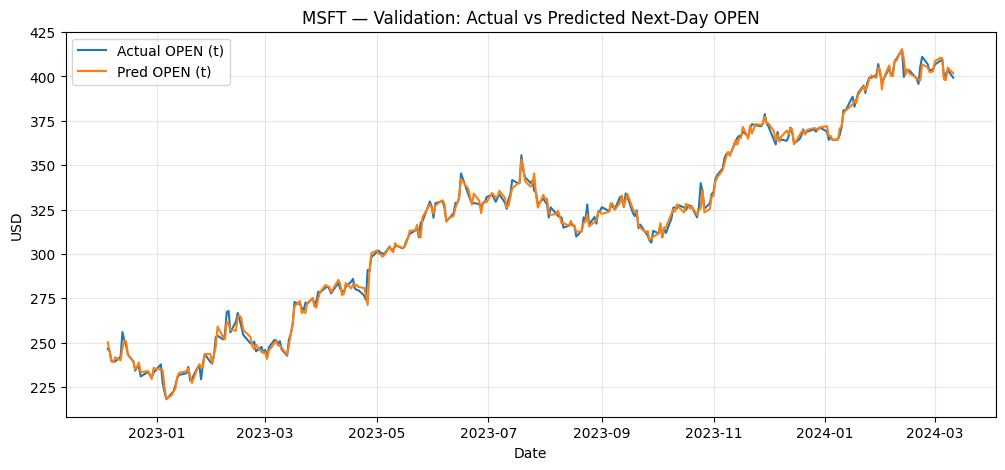

In [7]:
# Predict standardized overnight returns on validation
y_pred_std = model.predict(X_val, verbose=0).ravel()
y_true_std = y_val.ravel()

# Back to log-returns
y_pred_log = scaler.inverse_transform(y_pred_std.reshape(-1,1)).ravel()
y_true_log = scaler.inverse_transform(y_true_std.reshape(-1,1)).ravel()

# Reconstruct Open: Ō_t = Prev_Close_t * exp(r̂_t)
pred_open = pc_val * np.exp(y_pred_log)
true_open = pc_val * np.exp(y_true_log)

# Metrics
mae  = mean_absolute_error(true_open, pred_open)
# rmse = mean_squared_error(true_open, pred_open, squared=False)
mape = (np.abs((true_open - pred_open)/np.maximum(1e-8, np.abs(true_open)))).mean()*100
r2   = r2_score(true_open, pred_open)
da   = (np.sign(pred_open - pc_val) == np.sign(true_open - pc_val)).mean()*100

print(f"📊 Validation — {ticker} OPEN")
print(f"  DA% : {da:.2f}")
print(f"  MAE : {mae:.4f}")
# print(f"  RMSE: {rmse:.4f}")
print(f"  MAPE: {mape:.2f}%")
print(f"  R²  : {r2:.4f}")

# Plot
val_dates = val_df.index[LOOKBACK:]
plt.figure(figsize=(12,5))
plt.plot(val_dates, true_open, label="Actual OPEN (t)")
plt.plot(val_dates, pred_open, label="Pred OPEN (t)")
plt.title(f"{ticker} — Validation: Actual vs Predicted Next-Day OPEN")
plt.xlabel("Date"); plt.ylabel("USD"); plt.grid(True, alpha=.3); plt.legend(); plt.show()


🔮 Cell 6 — Forecast N future OPENs (recursive) + plot

✅ Close base bundle loaded for prev-close path.
✅ OPEN forecast ready:


,prev_close_used,pred_overnight_logret,pred_open
date,,,
2025-09-15,509.899994,0.001747,510.791584
2025-09-16,509.874023,0.001765,510.774821
2025-09-17,509.640015,0.001471,510.390125
2025-09-18,509.623688,0.001598,510.438561
2025-09-19,510.495209,0.001285,511.151547


,prev_close_used,pred_overnight_logret,pred_open
date,,,
2025-10-20,532.908020,0.002774,534.388458
2025-10-21,533.665894,0.002617,535.064250
2025-10-22,534.445129,0.002203,535.623839
2025-10-23,535.060181,0.001655,535.946172
2025-10-24,535.710205,0.000773,536.124421


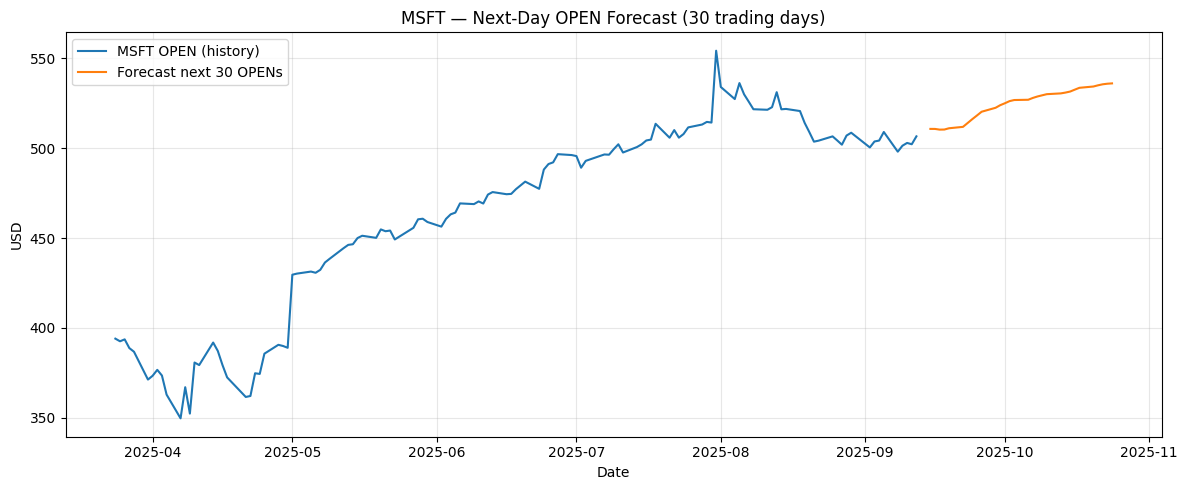

In [8]:
# Try to load Close base bundle for prev-close path (optional but better)
def try_load_close_bundle():
    mpath = os.path.join(CLOSE_BASE_DIR, "model.keras")
    spath = os.path.join(CLOSE_BASE_DIR, "scaler.pkl")
    cpath = os.path.join(CLOSE_BASE_DIR, "config.json")
    if not (os.path.exists(mpath) and os.path.exists(spath)):
        return None, None, None
    try:
        m = keras.models.load_model(mpath, custom_objects={"r2_metric": r2_metric})
        import joblib
        s = joblib.load(spath)
        cfg = json.load(open(cpath)) if os.path.exists(cpath) else {}
        return m, s, cfg
    except Exception:
        return None, None, None

close_model, close_scaler, close_cfg = try_load_close_bundle()
if close_model is None:
    print("ℹ️ Close base bundle not found — using fallback prev-close path.")
else:
    print("✅ Close base bundle loaded for prev-close path.")
    CLOSE_LOOKBACK = int(close_cfg.get("lookback", LOOKBACK)) if isinstance(close_cfg, dict) else LOOKBACK

def build_prev_close_path_via_close_model(n_steps: int):
    if close_model is None: return None
    close_series = ohlc["Close"].copy()
    ret_close = pd.DataFrame({"LogRet": np.log(close_series).diff()}).dropna()
    std_close = pd.DataFrame(
        close_scaler.transform(ret_close[["LogRet"]]),
        index=ret_close.index, columns=["LogRet"]
    )
    L = CLOSE_LOOKBACK
    if len(std_close) < L: return None
    window = std_close.values[-L:].astype(np.float32).reshape(L, 1)
    last_close = float(close_series.iloc[-1])

    preds_close, cur, prev = [], window.copy(), last_close
    for _ in range(n_steps):
        y_std = float(close_model.predict(cur.reshape(1, L, 1), verbose=0).ravel()[0])
        y_log = float(close_scaler.inverse_transform([[y_std]])[0, 0])
        nxt   = prev * np.exp(y_log)
        preds_close.append(nxt)
        cur = np.vstack([cur[1:], [[y_std]]]); prev = nxt

    prev_closes = np.empty(n_steps, dtype=np.float32)
    prev_closes[0] = last_close
    if n_steps > 1: prev_closes[1:] = np.asarray(preds_close[:-1], dtype=np.float32)
    return prev_closes

# Seed window for OPEN overnight returns
combined_std = pd.concat([train_sc["OvernightLogRet"], val_sc["OvernightLogRet"], test_sc["OvernightLogRet"]]).sort_index()
assert len(combined_std) >= LOOKBACK, "Not enough history to seed."
seed_window = combined_std.values[-LOOKBACK:].astype(np.float32).reshape(LOOKBACK, 1)

# Future dates
future_idx = future_trading_days(ovr_df.index.max(), N_FUTURE)

# Build prev-close path (or fallback)
prev_close_path = build_prev_close_path_via_close_model(N_FUTURE) if close_model is not None else None

pred_std, pred_log, pred_open_path, prev_used = [], [], [], []
cur = seed_window.copy()
prev_for_step = float(ovr_df["Prev_Close"].iloc[-1])

for k in range(N_FUTURE):
    if prev_close_path is not None:
        prev_for_step = float(prev_close_path[k])
    y_std = float(model.predict(cur.reshape(1, LOOKBACK, 1), verbose=0).ravel()[0])
    y_log = float(scaler.inverse_transform([[y_std]])[0, 0])
    o_hat = prev_for_step * np.exp(y_log)

    pred_std.append(y_std); pred_log.append(y_log); pred_open_path.append(o_hat); prev_used.append(prev_for_step)
    cur = np.vstack([cur[1:], [[y_std]]])

    if prev_close_path is None:
        prev_for_step = o_hat  # fallback proxy: use last predicted OPEN as next prev-close

forecast_open_df = pd.DataFrame({
    "prev_close_used": prev_used,
    "pred_overnight_logret": pred_log,
    "pred_open": pred_open_path,
}, index=future_idx)
forecast_open_df.index.name = "date"

print("✅ OPEN forecast ready:")
display(forecast_open_df.head()); display(forecast_open_df.tail())

# Plot: last 120 OPENs + forecast
hist_days = 120
hist = ohlc.tail(hist_days).copy()
plt.figure(figsize=(12,5))
plt.plot(hist.index, hist["Open"], label=f"{ticker} OPEN (history)")
plt.plot(forecast_open_df.index, forecast_open_df["pred_open"], label=f"Forecast next {N_FUTURE} OPENs")
plt.title(f"{ticker} — Next-Day OPEN Forecast ({N_FUTURE} trading days)")
plt.xlabel("Date"); plt.ylabel("USD"); plt.grid(True, alpha=.3); plt.legend(); plt.tight_layout(); plt.show()
